# Bayesian Gaussian Mixture Modeling using TensorFlow Probability

In [1]:
import os

import tensorflow as tf
import tensorflow_probability as tfp
tfb = tfp.bijectors
tfd = tfp.distributions
# tf.compat.v1.enable_eager_execution()

import sys
import functools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from operator import mul
from sklearn.cluster import KMeans

%matplotlib inline

print('TensorFlow version:', tf.__version__)
print('TensorFlow Probability version:', tfp.__version__)


  TensorFlow's `tf-nightly` package will soon be updated to TensorFlow 2.0.

  Please upgrade your code to TensorFlow 2.0:
    * https://www.tensorflow.org/beta/guide/migration_guide

  Or install the latest stable TensorFlow 1.X release:
    * `pip install -U "tensorflow==1.*"`

  Otherwise your code may be broken by the change.

  
TensorFlow version: 1.15.0-dev20190821
TensorFlow Probability version: 0.9.0-dev20191002


In [2]:
def session_options(enable_gpu_ram_resizing=True):
    """Convenience function which sets common `tf.Session` options."""
    config = tf.ConfigProto()
    config.log_device_placement = True
    if enable_gpu_ram_resizing:
        # `allow_growth=True` makes it possible to connect multiple colabs to your
        # GPU. Otherwise the colab malloc's all GPU ram.
        config.gpu_options.allow_growth = True
    return config

def reset_sess(config=None):
    """Convenience function to create the TF graph and session, or reset them."""
    if config is None:
        config = session_options()
    tf.reset_default_graph()
    global sess
    try:
        sess.close()
    except:
        pass
    sess = tf.InteractiveSession(config=config)

reset_sess()

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Quadro P1000, pci bus id: 0000:01:00.0, compute capability: 6.1



## Generate some data

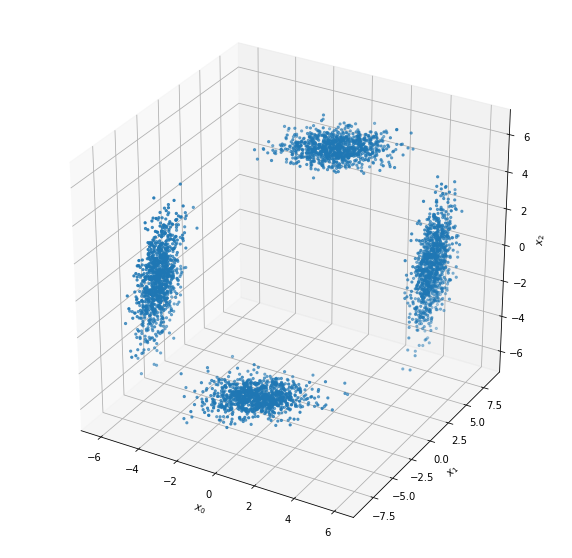

In [3]:
eps = 1e-6

n_samples_per_component = 1000
n_dims = 3
X = []
X.append(np.random.multivariate_normal([5, 5, 0],
                                       [[0.1, 0, 0], [0, 1, 0.6], [0, 0.6, 2]],
                                       n_samples_per_component).astype('float64'))
X.append(np.random.multivariate_normal([-5, -5, 0],
                                       [[0.1, 0, 0], [0, 1, 0.6], [0, 0.6, 2]],
                                       n_samples_per_component).astype('float64'))
X.append(np.random.multivariate_normal([0, 5, 5],
                                       [[1, 0.6, 0], [0.6, 1, 0], [0, 0, 0.2]],
                                       n_samples_per_component).astype('float64'))
X.append(np.random.multivariate_normal([0, -5, -5],
                                       [[1, 0.6, 0], [0.6, 1, 0], [0, 0, 0.2]],
                                       n_samples_per_component).astype('float64'))
n_components = len(X)
n_samples = n_samples_per_component * n_components
X = np.concatenate(X)

# Plot the data
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], marker='.')
ax.set_xlabel('$x_0$')
ax.set_ylabel('$x_1$')
ax.set_zlabel('$x_2$')
plt.show()

## Build a Gaussian Mixture Model
$$
\begin{aligned}
\mathbf{x}_n &\sim \sum\limits_k \pi_k \mathcal{N}\left(\pmb{\mu_x}_k, \pmb{\Sigma_x}_k\right)\\
\pi_k &\sim \mathcal{D}\left(K, \mathbf{c}\right)\\
\forall k \quad&\left\{
    \begin{aligned}
    \pmb{\Sigma_x}_k^{-1}|\mathbf{W}_k, \nu_k &\sim \mathcal{W}\left(\mathbf{W}_k, \nu_k\right)\\
    \pmb{\mu_x}_k|{\pmb{\mu_0}}_k, \lambda_k, \pmb{\Sigma_x}_k^{-1} &\sim \mathcal{N}\left({\pmb{\mu_0}}_k, {\left(\lambda_k\pmb{\Sigma_x}_k^{-1}\right)}^{-1}\right)
    \end{aligned}
\right.
\end{aligned}
$$

### prior distributions

In [4]:
theta_prior = tfd.Dirichlet(
    concentration=2 * np.ones(n_components, dtype=np.float64), name='theta_prior',
    validate_args=True, allow_nan_stats=False)

mu_prior = tfd.Independent(
    tfd.Normal(loc=np.stack([np.zeros(n_dims, dtype=np.float64)] * n_components),
               scale=tf.ones((n_components, n_dims), dtype=np.float64),
               validate_args=True, allow_nan_stats=False),
    reinterpreted_batch_ndims=1,
    name='mu_prior',
    validate_args=True)

invcov_chol_prior = tfd.Wishart(df=n_dims+2,
                           scale_tril=np.stack([np.eye(n_dims, dtype=np.float64)] * n_components),
                           input_output_cholesky=True,
                           name='invcov_chol_prior',
                           validate_args=True, allow_nan_stats=False)

### joint log probability

In [5]:
def joint_log_prob(x, theta, mu, invcov_chol):
    """BGMM with priors: loc=Normal, precision=Inverse-Wishart, mix=Dirichlet.

    Args:
    obs: `[n, d]`-shaped `Tensor` representing Bayesian Gaussian Mixture model draws.
         Each sample is a length-`d` vector.
    theta: `[K]`-shaped `Tensor` representing random draw from `SoftmaxInverse(Dirichlet)` prior.
    mu: `[K, d]`-shaped `Tensor` representing the location parameter of the `K` components.
    invcov_chol: `[K, d, d]`-shaped `Tensor` representing `K` lower triangular `cholesky(Precision)` matrices,
                 each being sampled from a Wishart distribution.

    Returns:
    log_prob: `Tensor` representing joint log-density over all inputs.
    """
    cov = tf.linalg.inv(tf.matmul(invcov_chol, tf.linalg.matrix_transpose(invcov_chol)))

    gmm = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(probs=theta),
        components_distribution=tfd.MultivariateNormalTriL(loc=mu,
                                                           scale_tril=tf.linalg.cholesky(cov)))
    log_prob_parts = [
        gmm.log_prob(x),                        # Sum over samples
        theta_prior.log_prob(theta)[..., tf.newaxis],
        mu_prior.log_prob(mu),                  # Sum over components
        invcov_chol_prior.log_prob(invcov_chol) # Sum over components
    ]
    sum_log_prob = tf.reduce_sum(tf.concat(log_prob_parts, axis=-1), axis=-1)
    # Note: for easy debugging, uncomment the following:
    # sum_log_prob = tf.Print(sum_log_prob, log_prob_parts)
    return sum_log_prob

## Bayesian Inference using HMC

In [6]:
unnormalized_posterior_log_prob = functools.partial(joint_log_prob, X)

### set up initial states

In [7]:
initial_state = [
    (1 / n_components) * tf.ones(n_components, dtype=tf.float64, name='theta'),
    tf.convert_to_tensor(np.array([[5, 5, 0],
                                   [-5, -5, 0],
                                   [0, 5, 5],
                                   [0, -5, -5]], dtype=np.float64),
                         name='mu'),
    tf.matrix_diag(tf.ones((n_components, n_dims), dtype=tf.float64), name='invcov_chol')
]

### unconstrained representation
Hamiltonian Monte Carlo (HMC) requires the target log-probability function be differentiable with respect to its arguments. Furthermore, HMC can exhibit dramatically higher statistical efficiency if the state-space is unconstrained.

To address this requirement we'll need to:

1. transform the constrained variables to an unconstrained space;
2. run the MCMC in unconstrained space;
3. transform the unconstrained variables back to the constrained space.


In [8]:
# bijectors transforms the unconstrained variables back to the constrained space
unconstraining_bijectors = [
    tfb.SoftmaxCentered(),
    tfb.Identity(),
    tfb.Chain([tfb.TransformDiagonal(tfb.Softplus()),
               tfb.FillTriangular()])
]

### graph for Hamiltonian Monte Carlo (HMC) sampling

In [9]:
n_results = 4000
n_burnin_steps = 2000
[theta, mu, invcov_chol], kernel_results = tfp.mcmc.sample_chain(num_results=n_results,
                                                                 num_burnin_steps=n_burnin_steps,
                                                                 current_state=initial_state,
                                                                 kernel=tfp.mcmc.TransformedTransitionKernel(
                                                                     inner_kernel=tfp.mcmc.HamiltonianMonteCarlo(
                                                                         target_log_prob_fn=unnormalized_posterior_log_prob,
                                                                         step_size=0.015,
                                                                         num_leapfrog_steps=10),
                                                                     bijector=unconstraining_bijectors))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


C:\ProgramData\Anaconda3\envs\nightly\lib\site-packages\tensorflow_probability\python\mcmc\sample.py:336: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn("Tracing all kernel results by default is deprecated. Set "


### launch the graph and display the inferred statistics

In [10]:
acceptance_rate = tf.reduce_mean(tf.to_float(kernel_results.inner_results.is_accepted))

theta = theta[n_burnin_steps:]
mu = mu[n_burnin_steps:]
invcov_chol = invcov_chol[n_burnin_steps:]
cov = tf.linalg.inv(tf.matmul(invcov_chol, tf.linalg.matrix_transpose(invcov_chol)))

mean_theta = tf.reduce_mean(theta, axis=0)
mean_mu = tf.reduce_mean(mu, axis=0)
mean_invcov_chol = tf.reduce_mean(invcov_chol, axis=0)
mean_cov = tf.reduce_mean(cov, axis=0)

[val_acceptance_rate, val_mean_theta, val_mean_mu, val_mean_invcov_chol, val_mean_cov] = sess.run(
    [acceptance_rate, mean_theta, mean_mu, mean_invcov_chol, mean_cov])

print('acceptance_rate:', val_acceptance_rate)
print('avg mix probs:', val_mean_theta)
print('\navg loc:\n', val_mean_mu)
print('\navg precision cholesky:\n', val_mean_invcov_chol)
print('\navg covariance matrix:\n', val_mean_cov)

Instructions for updating:
Use `tf.cast` instead.
acceptance_rate: 0.3295
avg mix probs: [0.25016027 0.25018305 0.24982084 0.24983584]

avg loc:
 [[ 5.0120545   4.99396342  0.03463635]
 [-5.01345461 -4.97873444 -0.06435826]
 [ 0.02311988  5.03403572  4.98135782]
 [ 0.02898792 -4.99161167 -4.98799529]]

avg precision cholesky:
 [[[ 3.15447583  0.          0.        ]
  [ 0.03338839  1.12046827  0.        ]
  [-0.0223388  -0.35605285  0.68317133]]

 [[ 3.11890195  0.          0.        ]
  [-0.0499619   1.11241182  0.        ]
  [-0.00992347 -0.37067878  0.70825077]]

 [[ 1.27428208  0.          0.        ]
  [-0.80881431  0.99298481  0.        ]
  [-0.04945783 -0.03696967  2.29243777]]

 [[ 1.30826324  0.          0.        ]
  [-0.76804252  0.96938897  0.        ]
  [ 0.05824075 -0.0559151   2.26010802]]]

avg covariance matrix:
 [[[ 1.00960000e-01 -5.94140787e-03  7.95051196e-03]
  [-5.94140787e-03  1.01525222e+00  6.81817625e-01]
  [ 7.95051196e-03  6.81817625e-01  2.14557674e+00]]

